# Compare Atomic Files

This notebook shows how to compare the `levels_prepared` and `lines_prepared` DataFrames of the atomic files generated by Carsus.

In [5]:
import os
import pandas as pd
import numpy as np
from carsus.util import parse_selected_species
from collections import defaultdict
from carsus.io.nist import NISTWeightsComp, NISTIonizationEnergies
from carsus.io.kurucz import GFALLReader
from carsus.io.zeta import KnoxLongZeta
from carsus.io.chianti_ import ChiantiReader
from carsus.io.output import TARDISAtomData
from carsus.io.util import AtomDataCompare

In [2]:
ATOM1_PATH = os.environ.get("ATOM1_PATH", None)
ATOM2_PATH = os.environ.get("ATOM2_PATH", None)

Define the following functions to compare both dataframes.

In [6]:
def highlight_values(val):
    if val == True:
        return 'background-color: #BCF5A9'
    else:
        return 'background-color: #F5A9A9'
    
def highlight_diff(val):
    if val == 0:
        return 'background-color: #BCF5A9'
    else:
        return 'background-color: #F5A9A9'

In [14]:
class AtomDataCompare:
    def __init__(self, d1_path=None, d2_path=None):
        self.d1_path = d1_path
        self.d2_path = d2_path
        self.setup()

        self.levels1 = (
            self.d1["levels_data"]
            if "/levels_data" in self.d1.keys()
            else self.d1["levels"]
        )
        self.levels2 = (
            self.d2["levels_data"]
            if "/levels_data" in self.d2.keys()
            else self.d2["levels"]
        )
        self.level_columns = ["energy", "g", "metastable"]

    def setup(self):
        self.d1 = pd.HDFStore(self.d1_path)
        self.d2 = pd.HDFStore(self.d2_path)

    def teardown(self):
        self.d1.close()
        self.d2.close()

    def comparision_table(self):
        d1_keys = self.d1.keys()
        d2_keys = self.d2.keys()
        self.d1_df = pd.DataFrame(index=d1_keys, columns=["exists"])
        self.d2_df = pd.DataFrame(index=d2_keys, columns=["exists"])
        self.d1_df["exists"] = True
        self.d2_df["exists"] = True
        joined_df = self.d1_df.join(self.d2_df, how="outer", lsuffix="_1", rsuffix="_2")
        joined_df = joined_df.fillna(False)
        self.tt = joined_df

    def compare(self, exclude_correct_matches=True):
        self.tt["match"] = None
        for index, row in self.tt.iterrows():
            if row[["exists_1", "exists_2"]].all():
                row1_df = self.d1[index]
                row2_df = self.d2[index]
                if row1_df.equals(row2_df):
                    self.tt.at[index, "match"] = True
                else:
                    self.tt.at[index, "match"] = False
            else:
                self.tt.at[index, "match"] = False

        # # collision_difference
        # self.col1 = (
        #     self.d1["collisions_data"]
        #     if "/collisions_data" in self.d1.keys()
        #     else self.d1["collision_data"]
        # )
        # self.col2 = (
        #     self.d2["collisions_data"]
        #     if "/collisions_data" in self.d2.keys()
        #     else self.d2["collision_data"]
        # )
        # col1_ions = self.col1.index.get_level_values("atomic_number").unique()
        # col2_ions = self.col2.index.get_level_values("atomic_number").unique()
        # self.col_ion_diff = len(
        #     set(col1_ions).symmetric_difference(set(col2_ions))
        # )  # TODO

        if exclude_correct_matches:
            self.tt = self.tt[self.tt.match == False]

    def levels_diff(self, ion, rtol=1e-07):
        parsed_ion = parse_selected_species(ion)[0]
        df1 = self.levels1.loc[parsed_ion]
        df2 = self.levels2.loc[parsed_ion]

        merged_levels = pd.merge(
            df1, df2, left_index=True, right_index=True, suffixes=["_1", "_2"]
        )

        for item in self.level_columns:
            if item != "metastable":
                merged_levels["matches_" + item] = np.isclose(
                    merged_levels[item + "_1"], merged_levels[item + "_2"], rtol=rtol
                )

                merged_levels["pct_change_" + item] = merged_levels[
                    [item + "_1", item + "_2"]
                ].pct_change(axis=1)[item + "_2"]

                merged_levels["pct_change_" + item] = merged_levels[
                    "pct_change_" + item
                ].fillna(0)

            else:
                merged_levels["matches_" + item] = (
                    merged_levels[item + "_1"] == merged_levels[item + "_2"]
                )

        # storing the original dataframe as an attribute
        setattr(self, "merged_levels_" + ion, merged_levels)
        return merged_levels

    def simplified_df(self, df):
        df_simplified = df.drop(df.filter(regex="_1$|_2$").columns, axis=1)
        return df_simplified

    def merged_levels_styled(self, ion, simplify_df=True):
        if hasattr(self, "merged_levels_" + ion):
            merged_levels = getattr(self, "merged_levels_" + ion)
        else:
            merged_levels = self.levels_diff(ion=ion)
        if simplify_df:
            merged_levels = self.simplified_df(merged_levels)
        subset = ["matches_" + item for item in self.level_columns]
        return merged_levels.style.applymap(highlight_values, subset=[*subset])

    @property
    def tt_stylized(self):
        return self.tt.style.applymap(
            highlight_values, subset=["exists_1", "exists_2", "match"]
        )


In [15]:
pat = "/home/atharva/workspace/code/tardis-main/carsus/kurucz_cd23_chianti_He_cmfgen_H_Si_I-II.h5"
pat2 = "/home/atharva/workspace/code/tardis-main/refdata/atom_data/kurucz_cd23_chianti_H_He.h5"
atc=AtomDataCompare(pat, pat2)
atc.setup()
atc.comparision_table()
atc.compare()
atc.levels_diff(ion="Fe")
atc.teardown()
atc.tt

,exists_1,exists_2,match
/atom_data,True,True,False
/collision_data,False,True,False
/collision_data_temperatures,False,True,False
/collisions_data,True,False,False
/collisions_metadata,True,False,False
/ionization_data,True,True,False
/levels,False,True,False
/levels_data,True,False,False
/lines,False,True,False
/lines_data,True,False,False


In [16]:
atc.merged_levels_styled(ion='H')

,matches_energy,pct_change_energy,matches_g,pct_change_g,matches_metastable
level_number,,,,,
0,True,0.000000,True,0.000000,True
1,False,-0.000002,False,-0.750000,True
2,False,-0.156252,False,-0.888889,False
3,False,-0.199998,False,-0.875000,True
4,False,-0.074075,False,-0.960000,True
5,False,-0.085715,False,-0.972222,True
6,False,-0.092592,False,-0.959184,True
7,False,-0.097001,False,-0.968750,True
8,False,-0.099999,False,-0.962963,True


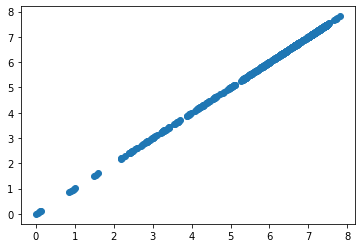

In [134]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(atc.merged_levels.energy_2, atc.merged_levels.energy_1,)

In [54]:
np.testing.assert_allclose(atc.d1['lines_data'].loc[(3,0,)]['line_id'].values, atc.d1['lines_data'].loc[(3,0,)]['line_id'].unique())

[                py.warnings][WARNING] - /home/atharva/miniconda3/envs/carsus-devel/lib/python3.7/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.
 (warnings.py:110)


fractional difference between energy
energy vs energy


In [ ]:
atc.d1['lines_data']

In [ ]:
atc.d1['collisions_data']

In [ ]:
atc.d2['collisions_data']

In [ ]:
atc.d2['lines']

In [ ]:
# concat = pd.concat([atc.d1['ionization_data'].rename("d1_ion"), atc.d2['ionization_data'].rename("d2_ion")], axis=1)

In [ ]:
def compare_levels_lines(path_a, path_b, ions='H-Zn'):
    
    # Read data
    levels_a = pd.read_hdf(path_a, key='levels_data')
    levels_b = pd.read_hdf(path_b, key='levels_data')
    lines_a = pd.read_hdf(path_a, key='lines_data')
    lines_b = pd.read_hdf(path_b, key='lines_data')
    
    # Get ions list
    ions = parse_selected_species(ions)
    
    lvl_eq = []
    lns_eq = []
    for ion in ions:
        
        # How many levels per ion in A
        try:
            num_lvl_a = len(levels_a.loc[ion])
            
        except (KeyError, TypeError, ValueError):
            num_lvl_a = 0
            
        # How many levels per ion in B
        try:
            num_lvl_b = len(levels_b.loc[ion])
            
        except (KeyError, TypeError, ValueError):
            num_lvl_b = 0

        # If level number is the same in A and B (and not zero) 
        # then compare cell against cell. `True` means all cells 
        # are equal in both dataframes.
        if num_lvl_a == num_lvl_b:
            val_lvl = True
            
            if num_lvl_a != 0:
                try:
                    k = levels_a.loc[ion].eq(levels_b.loc[ion]).sum().sum()
                    if num_lvl_a*3 != k:  # x3 because this df has three columns!
                        val_lvl = False
                        
                except (KeyError, TypeError, ValueError):
                    pass

        else:
            val_lvl = False
            
        # Append the results
        lvl_eq.append((ion, num_lvl_a, num_lvl_b, val_lvl))
        
        
        # Same for lines
        try:
            num_lns_a = len(lines_a.loc[ion])
            
        except (KeyError, TypeError, ValueError):
            num_lns_a = 0
            
        try:
            num_lns_b = len(lines_b.loc[ion])
            
        except (KeyError, TypeError, ValueError):
            num_lns_b = 0

        if num_lns_a == num_lns_b:
            val_lns = True
            
            if num_lns_a != 0:
                try:
                    k = lines_a.loc[ion].eq(lines_b.loc[ion]).sum().sum()
                    if num_lns_a*8 != k:
                        val_lvl = False
            
                except (KeyError, TypeError, ValueError):
                    pass
            
        else:
            val_lns = False
        
        lns_eq.append((ion, num_lns_a, num_lns_b, val_lns))
            
    df_lvl = pd.DataFrame(lvl_eq, columns=['ion', 'num_lvl_a', 'num_lvl_b', 'val_lvl'])
    df_lns = pd.DataFrame(lns_eq, columns=['ion', 'num_lns_a', 'num_lns_b', 'val_lns'])
    df = pd.merge(df_lvl, df_lns).set_index('ion')
    
    df['diff_lvl'] = abs(df['num_lvl_b'] - df['num_lvl_a'])
    df['diff_lns'] = abs(df['num_lns_b'] - df['num_lns_a'])
    df = df[['num_lvl_a', 'num_lvl_b', 'diff_lvl', 'val_lvl', 
          'num_lns_a', 'num_lns_b', 'diff_lns', 'val_lns']]

    return df

### Custom Atomic Data

To generate and compare atomic data files locally, please uncomment the code below.<br>
For the first atomic file we grab species `H-C` from GFALL and `H-He` from Chianti.

In [ ]:
# atomic_weights = NISTWeightsComp()
# ionization_energies = NISTIonizationEnergies('H-C')
# gfall_reader = GFALLReader(ions='H-C')
# chianti_reader = ChiantiReader(ions='H-He', collisions=True, priority=20)
# zeta_data = KnoxLongZeta()

In [ ]:
# atom_data_a = TARDISAtomData(atomic_weights,
#                              ionization_energies,
#                              gfall_reader,
#                              zeta_data,
#                              chianti_reader)

In [ ]:
# atom_data_a.to_hdf('A.h5')

For the second atomic file we grab species `H-C` from GFALL and `C` from Chianti.

In [ ]:
# chianti_reader = ChiantiReader(ions='C', collisions=True, priority=20)

In [ ]:
# atom_data_b = TARDISAtomData(atomic_weights,
#                              ionization_energies,
#                              gfall_reader,
#                              zeta_data,
#                              chianti_reader)

In [ ]:
# atom_data_b.to_hdf('B.h5')

In [ ]:
# tt = compare_levels_lines('A.h5', 'B.h5', ions='H-C')

```
num_xxx_y (int) : number of levels/lines.
diff_xxx (int) : difference in number of levels/lines.
val_xxx (bool) : `True` if levels/lines have the same value.
```

In [ ]:
tt.style.applymap(highlight_values, subset=['val_lvl', 'val_lns']).applymap(
                    highlight_diff, subset=['diff_lvl', 'diff_lns'])